In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import numpy as np

from random import randint
import matplotlib.pyplot as plt

import glob
import os
import urllib.request
import time

In [2]:

def load_data(root, test_ratio=0.2, max_items_per_class=10000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    # initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    # load each data file
    for idx, file in enumerate(all_files):
        class_name = file.split('.')[0]
        class_names.append(class_name)

        data = np.load(file)
        # print('class[%s] has %d samples' % (class_name, data.shape[0]))
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.append(x, data, axis=0)
        y = np.append(y, labels)

    data = None
    labels = None

    # randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    # separate into training and testing
    test_size = int(x.shape[0]/100*(test_ratio*100))

    x_test = x[0:test_size, :]
    y_test = y[0:test_size]

    x_train = x[test_size:, :]
    y_train = y[test_size:]
    return x_train, y_train, x_test, y_test, class_names

In [3]:
x_train, y_train, x_test, y_test, class_names = load_data('data', max_items_per_class=100)
num_classes = len(class_names)
image_size = 28
num_classes

50

In [14]:
print('x_train shape: ', x_train.shape)
assert x_train.shape[0] == y_train.shape[0]
assert x_test.shape[0] == y_test.shape[0]

x_train shape:  (169600, 784)


data\tooth


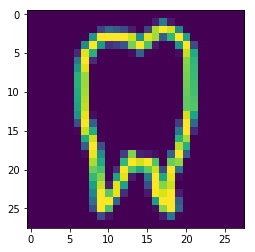

In [12]:
"""Show some random data"""
idx = randint(0, len(x_train))
rand_x = x_train[idx].reshape(28, 28)
plt.imshow(rand_x)
print(class_names[int(y_train[idx].item())])

In [16]:

"""# Preprocess the Data"""

# Reshape and normalize
x_train = x_train.reshape(
    x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(
    x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [17]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                               padding='same',
                               input_shape=(image_size, image_size, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 128)         73856     
__________

In [18]:

# compile model
adam = tf.train.AdamOptimizer()

# top-N
TOP_N = 5

def top_n_categorical_accuracy(y_pred, y_label):
    return metrics.top_k_categorical_accuracy(y_pred, y_label, k=TOP_N)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy', top_n_categorical_accuracy])


In [19]:
starttime = time.time()

"""# Training"""

history = model.fit(x=x_train, y=y_train, validation_split=0.1, batch_size=128, verbose=1, epochs=10)

cost_time = time.time() - starttime
print('cost time {:.0f}m{:.0f}s'.format(cost_time/60, cost_time%60))

Train on 152640 samples, validate on 16960 samples
Epoch 1/10
152640/152640 [==============================] - 184s 1ms/step - loss: 1.5598 - acc: 0.5929 - top_n_categorical_accuracy: 0.8361 - val_loss: 1.0897 - val_acc: 0.7186 - val_top_n_categorical_accuracy: 0.9070
Epoch 2/10
152640/152640 [==============================] - 188s 1ms/step - loss: 0.9591 - acc: 0.7484 - top_n_categorical_accuracy: 0.9231 - val_loss: 0.8953 - val_acc: 0.7692 - val_top_n_categorical_accuracy: 0.9285
Epoch 3/10
152640/152640 [==============================] - 189s 1ms/step - loss: 0.8127 - acc: 0.7852 - top_n_categorical_accuracy: 0.9373 - val_loss: 0.8513 - val_acc: 0.7774 - val_top_n_categorical_accuracy: 0.9325
Epoch 4/10
152640/152640 [==============================] - 199s 1ms/step - loss: 0.7293 - acc: 0.8053 - top_n_categorical_accuracy: 0.9450 - val_loss: 0.7718 - val_acc: 0.8003 - val_top_n_categorical_accuracy: 0.9407
Epoch 5/10
152640/152640 [==============================] - 179s 1ms/step - l

In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print('loss: {:.3f}, Test accurracy: {:.2f}%, top-{} accuarcy: {:0.2f}%'
      .format(score[0], score[1] * 100, TOP_N, score[2] * 100))

loss: 0.698, Test accurracy: 81.93%, top-5 accuarcy: 94.60%


In [21]:
"""# Inference"""

model.save('quickDraw.h5')

In [ ]:
#predict
idx = randint(0, len(x_test))
print(idx, x_test.shape, y_test.shape)
pred = model.predict(np.expand_dims(x_test[idx], axis=0))
print(pred.shape)

pred1 = pred[0].argmax()
print(pred1)
print(int(y_test[idx].argmax().item()))
#pred2 = (-pred[0]).argsort()[:5]
#print(pred2)

plt.imshow(x_test[idx].squeeze()) 
print("%s %2.f%% %s" % (class_names[int(pred1.item())],pred[0][pred1]*100 , class_names[int(y_test[idx].argmax().item())]))